In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-multi-class-prediction-of-obesity-risk/data.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


# **銀行解約データセットを使用した二項分類**
Binary Classification with a Bank Churn Dataset(https://www.kaggle.com/competitions/playground-series-s4e1/code?competitionId=65711&sortBy=voteCount)

# 参考資料
**書籍**
- Python実践データ分析100本ノック
- Python実践AIモデル構築 100本ノック
- Python実践機械学習システム 100本ノック


**Kaggle**
- [[PlayGround S4E1] 📊 EDA + 🤖 Modeling [XGBoost]](https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost)
- [🏛️Binary Classification💸 | Bank Churn💰| EDA📈](https://www.kaggle.com/code/tarundirector/binary-classification-bank-churn-eda)


**自分で作成したファイル**
- 肝硬変の転帰の多クラス予測

**その他**


In [2]:
import numpy as np
import pandas as pd

FILE_PATH = '/kaggle/input/playground-series-s4e2/'
CREATE_DATA = '/kaggle/input/my-multi-class-prediction-of-obesity-risk'


# 確認 (data_import.py)
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    
    target_col = 'NObeyesdad'
    
    train = data[:20758].reset_index(drop=True)
    test = data[20758:].reset_index(drop=True).drop(target_col, axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop([target_col], axis=1) # 目的変数を指定する
    y = train[target_col].values # 目的変数を指定する

    return data,test,train,X,y

filename = 'data.csv'
data,test,train,X,y = file_to_xy(CREATE_DATA + '/' + filename)

読み込み完了 /kaggle/input/my-multi-class-prediction-of-obesity-risk/data.csv


/tmp/ipykernel_25/358891333.py:10: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, index_col=0)


In [3]:
X = X.copy()
y = y.copy()

# 機械学習モデルの構築・学習・予測

## ライブラリのインポート

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 評価指標
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

# 機械学習モデル
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 実験
import datetime
import pickle


sample_sub = pd.read_csv(FILE_PATH + "sample_submission.csv")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## データの分割

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## モデルの学習

### LinearRegression

In [6]:
# # 標準化する
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)

# lr = LinearRegression().fit(X_train_scaled, y_train)

### Lasso

In [7]:
# lasso = Lasso().fit(X_train, y_train)

### Ridge(回帰)

In [8]:
# ridge = Ridge().fit(X_train_scaled, y_train)

### LGBMClassifier

In [9]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 16
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625


LGBMClassifier(random_state=42)

### DecisionTreeClassifier

In [10]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 分割データの予測

### LinearRegression

In [11]:
# lr_train_pred = lr.predict(X_train_scaled)
# lr_valid_pred = lr.predict(X_valid_scaled)

# print(f"Train Score: {accuracy_score(y_train, lr_train_pred)}")
# print(f"Valid Score: {accuracy_score(y_valid, lr_valid_pred)}")

### Lasso

In [12]:
# lasso_train_pred = lasso.predict(X_train)
# lasso_valid_pred = lasso.predict(X_valid)

# print(f"Train Score: {roc_auc_score(y_train, lasso_train_pred)}")
# print(f"Valid Score: {roc_auc_score(y_valid, lasso_valid_pred)}")

### Ridge

In [13]:
# ridge_train_pred = lasso.predict(X_train_scaled)
# ridge_valid_pred = lasso.predict(X_valid_scaled)

# print(f"Train Score: {roc_auc_score(y_train, ridge_train_pred)}")
# print(f"Valid Score: {roc_auc_score(y_valid, ridge_valid_pred)}")

### LGBMClassifier

In [14]:
# lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
# lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
# print(f"Train Score: {accuracy_score(y_train, lgb_train_pred)}")
# print(f"Valid Score: {accuracy_score(y_valid, lgb_valid_pred)}")

### DecisionTreeClassifier

In [15]:
y_test_pred = dt.predict(X_valid)
print(y_test_pred)

['Obesity_Type_III' 'Overweight_Level_I' 'Obesity_Type_I' ...
 'Obesity_Type_I' 'Overweight_Level_I' 'Overweight_Level_I']


In [16]:
results_test = pd.DataFrame({"y_valid": y_valid,
                           "y_pred": y_test_pred})
results_test = results_test
results_test.head()

,y_valid,y_pred
0,Obesity_Type_III,Obesity_Type_III
1,Overweight_Level_I,Overweight_Level_I
2,Obesity_Type_I,Obesity_Type_I
3,Obesity_Type_II,Obesity_Type_II
4,Insufficient_Weight,Insufficient_Weight


In [17]:
print(dt.score(X_train, y_train))

1.0


### 特徴重要度を算出する

In [18]:
importance = pd.DataFrame({"feature_names": X.columns,
                          "coefficient": dt.feature_importances_})
importance

,feature_names,coefficient
0,Gender,0.194412
1,Age,0.040132
2,Height,0.142818
3,Weight,0.481392
4,family_history_with_overweight,0.006322
5,FAVC,0.011755
6,FCVC,0.017445
7,NCP,0.017399
8,CAEC,0.010198
9,SMOKE,0.000732


In [19]:
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance

,importance
SMOKE,54
SCC,155
FAVC,295
family_history_with_overweight,423
MTRANS,436
Gender,474
CAEC,523
CALC,631
NCP,1132
FCVC,1293


<Axes: >

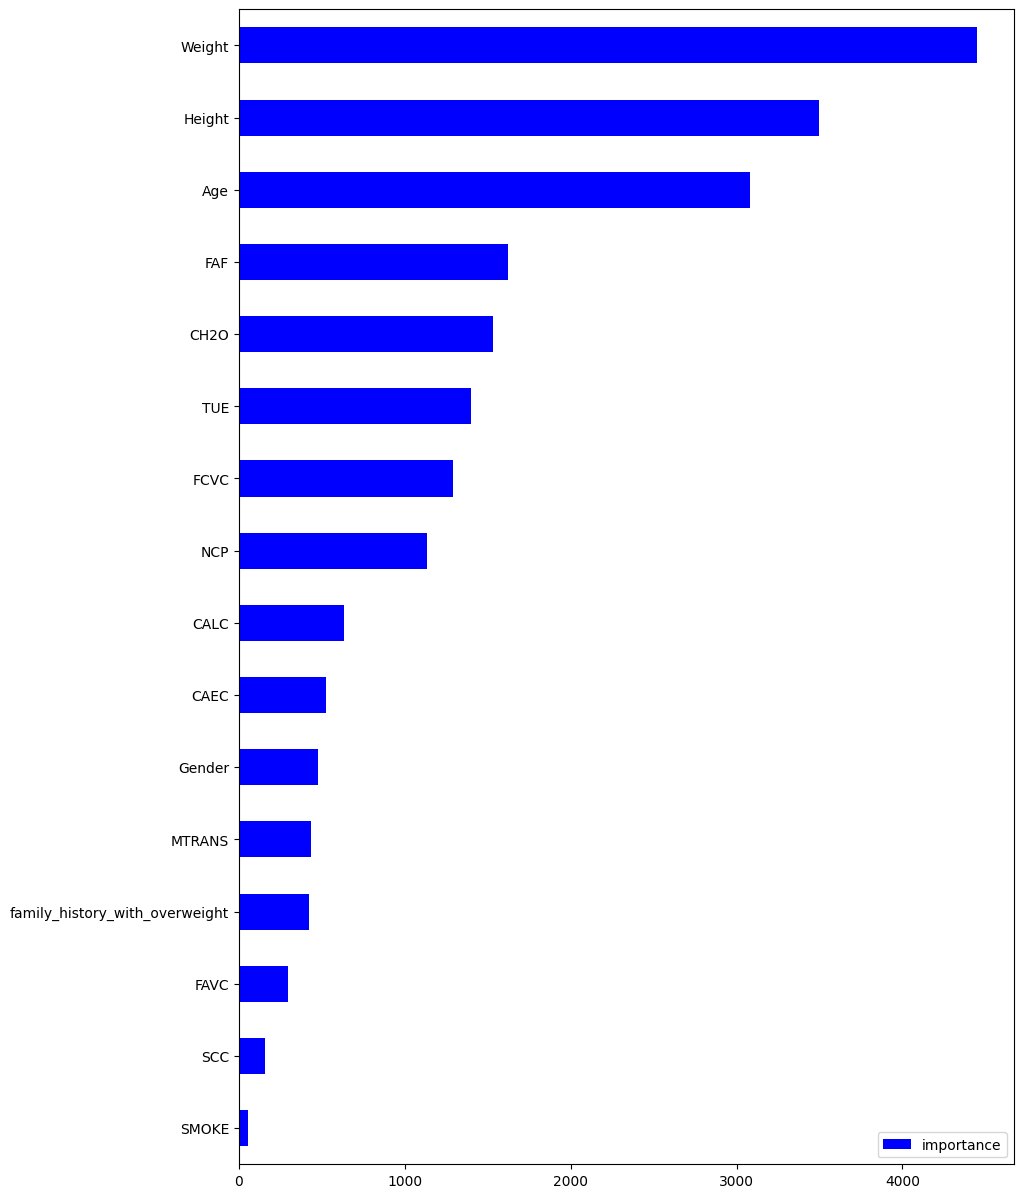

In [20]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

## モデルファイルと評価結果を出力する（ファイルの出力あり）

In [21]:
def make_model_and_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    # F1_score
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    # recall
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    recall_test = recall_score(y_test, y_pred_test, average='macro')
    # precision
    precision_train = precision_score(y_train, y_pred_train, average='macro')
    precision_test = precision_score(y_test, y_pred_test, average='macro')
    # AUC
#     auc_train = roc_auc_score(y_train, y_pred_train)
#     auc_test = roc_auc_score(y_test, y_pred_test)
    # MAE
#     mae_train = mean_absolute_error(y_train, y_pred_train)
#     mae_test = mean_absolute_error(y_test, y_pred_test)
    # MSE
#     mse_train = mean_squared_error(y_train, y_pred_train)
#     mse_test = mean_squared_error(y_test, y_pred_test)
    # RMSE
#     rmse_train = np.sqrt(mse_train)
#     rmse_test = np.sqrt(mse_test)
    # r2_score
#     r2_train = r2_score(y_train, y_pred_train)
#     r2_test = r2_score(y_test, y_pred_test)

#     tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
#     tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    score_train = pd.DataFrame({'DataCategory':['Train'],
#                                'auc':[auc_train],
                               'accuracy':[acc_train],
                               'f1':[f1_train],
                               'recall':[recall_train],
                               'precision':[precision_train],
#                                'MAE':[mae_train],
#                                'MSE':[mse_train],
#                                'RMSE':[rmse_train],
#                                'r2':[r2_train],
#                                'tp':[tp_train],
#                                'fn':[fn_train],
#                                'fp':[fp_train],
#                                'tn':[tn_train]
                               })
    score_test = pd.DataFrame({'DataCategory':['Valid'],
#                               'auc':[auc_test],
                              'accuracy':[acc_test],
                              'f1':[f1_test],
                              'recall':[recall_test],
                              'precision':[precision_test],
#                               'MAE':[mae_test],
#                               'MSE':[mse_test],
#                               'RMSE':[rmse_train],
#                               'r2':[r2_train],
#                               'tp':[tp_test],
#                               'fn':[fn_test],
#                               'fp':[fp_test],
#                               'tn':[tn_test]
                              })
    score = pd.concat([score_train, score_test], ignore_index=True)
    
    importance = pd.DataFrame({'cols': X_train.columns,
                              'importance': model.feature_importances_})
    importance = importance.sort_values('importance', ascending=False)
    cols = pd.DataFrame({'X_cols': X_train.columns})
    display(score)
    
    return score, importance, model, cols

In [22]:
now = datetime.datetime.now().strftime("%Y%m%d%H")
target_output_dir = 'results_' + now

os.makedirs(target_output_dir, exist_ok=True)
print(target_output_dir)



models = {'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42), 
          'RandomForest':RandomForestClassifier(random_state=42),
          'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
          'lightgbm': LGBMClassifier(random_state=42),
#           'xgboost': XGBClassifier(random_state=42)
         }

score_all = []
importance_all = []
for model_name, model in models.items():
    print(model_name)
    score, importance, model, cols = make_model_and_eval(model, X_train, X_valid, y_train, y_valid)
    score['model_name'] = model_name
    importance['model_name'] = model_name
    
    model_names = f'model_{model_name}.pickle'
    model_path = os.path.join(target_output_dir, model_names)
    with open(model_path, mode='wb') as f:
        pickle.dump(model, f, protocol=2)
    score_all.append(score)
    importance_all.append(importance)
score_all = pd.concat(score_all, ignore_index=True)
importance_all = pd.concat(importance_all, ignore_index=True)
cols = pd.DataFrame({'X_cols':X_train.columns})

score_name = 'score.csv'
importance_name = 'importance.csv'
cols_name = 'X_cols.csv'

score_path = os.path.join(target_output_dir, score_name)
importance_path = os.path.join(target_output_dir, importance_name)
cols_path = os.path.join(target_output_dir, cols_name)

score_all.to_csv(score_path, index=False)
importance_all.to_csv(importance_path, index=False)
cols.to_csv(cols_path, index=False)

results_2024020102
DecisionTreeClassifier


,DataCategory,accuracy,f1,recall,precision
0,Train,1.000000,1.000000,1.000000,1.000000
1,Valid,0.847303,0.831943,0.831859,0.832185


RandomForest


,DataCategory,accuracy,f1,recall,precision
0,Train,1.000000,1.000000,1.000000,1.000000
1,Valid,0.893064,0.881411,0.880445,0.882909


GradientBoostingClassifier


,DataCategory,accuracy,f1,recall,precision
0,Train,0.920330,0.911652,0.911558,0.911907
1,Valid,0.900771,0.890185,0.889953,0.890471


lightgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 16
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625


,DataCategory,accuracy,f1,recall,precision
0,Train,0.979766,0.977217,0.977060,0.977446
1,Valid,0.903420,0.893093,0.892806,0.893439


#### pickleファイルのインポート

In [23]:
import pickle

model_name = 'model_lightgbm.pickle'

model_path = os.path.join(target_output_dir, model_name)

with open(model_path, mode='rb') as f:
    model = pickle.load(f)
    
print(model)

LGBMClassifier(random_state=42)


## モデルの予測

In [24]:
target_col = 'NObeyesdad'
sample_sub[target_col] = model.predict(test)

# 提出

In [25]:
sample_sub.to_csv('submission.csv', index=False)

In [26]:
sample_sub.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [27]:
train[target_col].value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64